# Jupyter - hadoop quick start tutorial

## Preamble

In [1]:
### Preamble
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hadoop_tools_simple as ht

___

## Basic Jupyter commands
Jupyter has multiple modes, much like Vim. 
- If you see a blinking | in a cell, you're in edit mode. Esc to go to command mode.
- If you don't see a a blinking | in a cell, you're in. Enter to go into edit mode.

### Basic jupyter commands (edit mode)
- shift + enter: execute cell, move to next cell
- ctrl + enter: execute cell in place

In [2]:
print('Hello world!')

Hello world!


### Command mode shortcuts
- shift + enter: execute cell, move to next cell
- ctrl + enter: execute cell in place

### Edit mode shortcuts
- c - copy cell
- v - paste cell
- x - cut cell
- m - convert cell to markdown
- y - convert cell to code
- a - insert cell above
- b - insert cell below

In [3]:
# cell A

In [4]:
# cell B

### Additional tips
- You can create a new view of the same notebook
- Table of contexts plug in is really useful for jumping around the notebook

___

## Scenario: Basic hive and hadoop queries

In [5]:
# triple quotes allow you to have multiple lines
query = '''
    select
        -- indices
        if(array_contains(test_group_set_php.mantis_id, 57256L),
           'test', 'control') AS group_id,
        ssm.ymd as ymd,
        -- aggreates
        count(*) as visits,
        avg(ssm.pc_cos) as clickouts,
        avg(ssm.clickout_rev) as revenue
    from
        trivago_analytic.session_stats_master as ssm
    where
        ssm.crawler_id = 0
        and ssm.is_core
        and (array_contains(tags, 'releasecontrol'))
        -- ymd filter
        and ymd between 20210621 and 20210705
        -- traffic filter
        and (array_contains(control_group_set_php.mantis_id, 57256L)
             or array_contains(test_group_set_php.mantis_id, 57256L))
        and ssm.session_date_id between 2021062118*1e9 and 2021070523999999999
        and substr(cast(ssm.release_string as string), 1, 4) in ('9306', 'arp', '9307')
    group by    
        if(array_contains(test_group_set_php.mantis_id, 57256L),
           'test', 'control'),
        ssm.ymd
'''
df_sc = ht.query_hive(query)

In [6]:
df_sc.head()

,group_id,ymd,visits,clickouts,revenue
0,control,20210705,456892,0.534339,31.859464
1,control,20210626,1126983,0.592524,39.273687
2,control,20210627,1403879,0.630697,39.856624
3,test,20210623,1259677,0.581242,38.867968
4,control,20210625,1189522,0.567181,38.666562


In [7]:
# Pro-tip: Creating a pre-aggreated table in hive, then doing the final aggregation in 
#          impala usually speeds up 
query = '''
drop table if exists gleyson.basic_sanity_check;
create table gleyson.basic_sanity_check
    stored as parquet as
select
    -- indices
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control') AS group_id,
    ssm.ymd as ymd,
    -- aggreates
    count(*) as visits,
    avg(ssm.pc_cos) as clickouts,
    avg(ssm.clickout_rev) as revenue
from
    trivago_analytic.session_stats_master as ssm
where
    ssm.crawler_id = 0
    and ssm.is_core
    and (array_contains(tags, 'releasecontrol'))
    -- ymd filter
    and ymd between 20210621 and 20210705
    -- traffic filter
    and (array_contains(control_group_set_php.mantis_id, 57256L)
         or array_contains(test_group_set_php.mantis_id, 57256L))
    and ssm.session_date_id between 2021062118*1e9 and 2021070523999999999
    and substr(cast(ssm.release_string as string), 1, 4) in ('9306', 'arp', '9307')
group by    
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control'),
    ssm.ymd
'''
ht.query_hive(query)

In [8]:
query = '''
invalidate metadata gleyson.basic_sanity_check;
compute stats gleyson.basic_sanity_check
'''
ht.query_impala(query)

In [9]:
%%time
query = '''
select group_id, sum(visits) as total_visits
from gleyson.basic_sanity_check
group by group_id
'''
ht.query_hive(query)

CPU times: user 14.9 ms, sys: 4.23 ms, total: 19.1 ms
Wall time: 39.8 s


,group_id,total_visits
0,control,18099818
1,test,18098460


In [10]:
%%time
query = '''
select group_id, sum(visits) as total_visits
from gleyson.basic_sanity_check
group by group_id
'''
ht.query_impala(query)

CPU times: user 10.1 ms, sys: 2.99 ms, total: 13.1 ms
Wall time: 543 ms


,group_id,total_visits
0,test,18098460
1,control,18099818


___

## Scenario: Plotting revenue vs. ymd

In [11]:
# load dataset
df = df_sc

In [12]:
# peek at dataset head
df.head()

,group_id,ymd,visits,clickouts,revenue
0,control,20210705,456892,0.534339,31.859464
1,control,20210626,1126983,0.592524,39.273687
2,control,20210627,1403879,0.630697,39.856624
3,test,20210623,1259677,0.581242,38.867968
4,control,20210625,1189522,0.567181,38.666562


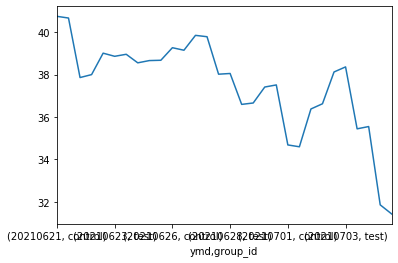

In [13]:
# basic plot
indices = ['ymd', 'group_id']
metric = 'revenue'

dfb = df.set_index(indices).sort_index()
dfb[metric].plot()

In [14]:
# format ymd column
df.ymd = pd.to_datetime(df.ymd, format='%Y%m%d')
df.head()

,group_id,ymd,visits,clickouts,revenue
0,control,2021-07-05,456892,0.534339,31.859464
1,control,2021-06-26,1126983,0.592524,39.273687
2,control,2021-06-27,1403879,0.630697,39.856624
3,test,2021-06-23,1259677,0.581242,38.867968
4,control,2021-06-25,1189522,0.567181,38.666562


In [15]:
# unstack group id
indices = ['ymd', 'group_id']
metric = 'revenue'
dfb = df.set_index(indices).sort_index()
dfb.head()

visits  clickouts    revenue
ymd        group_id                               
2021-06-21 control    438404   0.612141  40.753583
           test       438378   0.610001  40.673763
2021-06-22 control   1340993   0.573092  37.865916
           test      1345228   0.573738  38.004421
2021-06-23 control   1258548   0.583401  39.015757

In [61]:
dfb[metric].unstack('group_id').head(3)

group_id,control,test
ymd,,
2021-06-21,40.753583,40.673763
2021-06-22,37.865916,38.004421
2021-06-23,39.015757,38.867968


[Text(0, 0.5, 'revenue')]

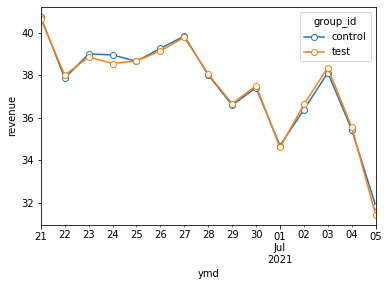

In [58]:
# basic (non-ugly) plot for revenue vs. time
plot_kws = dict(style='o-', mfc='w')
ax = dfb[metric].unstack('group_id').plot(**plot_kws)
ax.set(ylabel=metric)

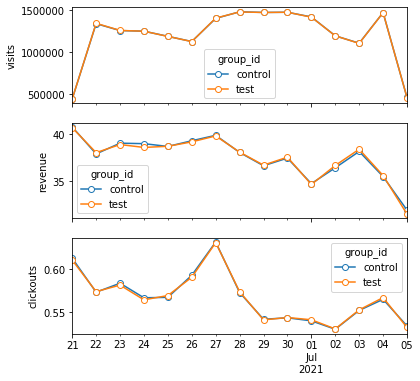

In [63]:
fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

metrics = ['visits', 'revenue', 'clickouts']
for ax, metric in zip(axs, metrics):
    ax = dfb[metric].unstack('group_id').plot(**plot_kws, ax=ax)
    ax.set(ylabel=metric, xlabel='')

[Text(0, 0.5, 'clickouts'), Text(0.5, 0, '')]

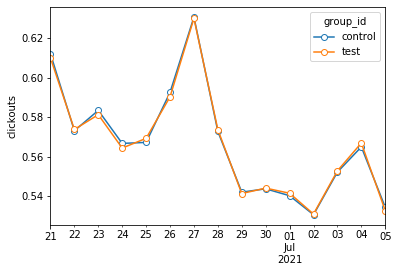

In [113]:
# Interactive plot
from ipywidgets import interact

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax = dfb[metric].unstack('group_id').plot(**plot_kws, ax=ax)
ax.set(ylabel=metric, xlabel='')
    

## Scenario - Basic exploratory analysis

- **Context**: Expect `relevance_score` to be equal to `(logged_ctr * priority * 1e3)`
- **Observation**: Sometimes this is not the case
- **Questions**
    - How frequent?
    - What causes the discrepancy?

In [16]:
query = '''
with cte as (
    select 
        relevance_score / (logged_ctr * priority * 1e3) as ratio
    from 
        anair.cpc_analysis_base_data
    where 
        first_hotel_sort_order = 'RELEVANCE'
        and second_hotel_sort_order is null
        and search_type = 'other'
        and is_beta = 'Not Beta'
)

select
    round(ratio, 2) as relratio,
    count(*) as instances
from cte
group by relratio
'''
df = ht.query_impala(query)

In [17]:
df['frac'] = df.instances / df.instances.sum()

In [18]:
df.head(3)

,relratio,instances,frac
0,5.08,15,7.221018e-07
1,17.61,2,9.628024e-08
2,0.73,2112,1.016719e-04


[Text(0, 0.5, 'fraction')]

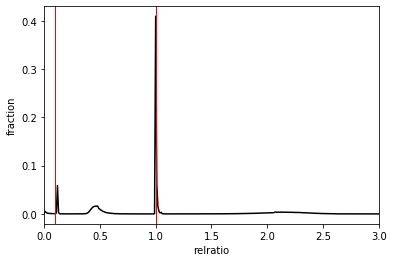

In [19]:
ax = df.set_index('relratio').sort_index().frac.plot(style='k-')
ax.set(xlim=[0, 3],
#        yscale='log'
      )

axline_kws = dict(color='r', linewidth=1)
ax.axvline(1, **axline_kws)
ax.axvline(0.1, **axline_kws)
ax.set(ylabel='fraction')

TODO: create cumulative plot

In [20]:
%%time
query = '''
with cte as (
    select 
        ymd,
        relevance_score / (logged_ctr * priority * 1e3) as ratio
    from anair.cpc_analysis_base_data
    where first_hotel_sort_order = 'RELEVANCE'
        and second_hotel_sort_order is null
        and search_type = 'other'
        and is_beta = 'Not Beta'
)

select
    ymd,
    round(ratio, 2) as relratio,
    count(*) as instances
from cte
group by ymd, relratio
'''
df = ht.query_impala(query)

CPU times: user 149 ms, sys: 18.5 ms, total: 168 ms
Wall time: 13.6 s


In [21]:
%%time
query = '''
with cte as (
    select 
        ymd,
        relevance_score / (logged_ctr * priority * 1e3) as ratio
    from anair.cpc_analysis_base_data
    where first_hotel_sort_order = 'RELEVANCE'
        and second_hotel_sort_order is null
        and search_type = 'other'
        and is_beta = 'Not Beta'
)

select
    ymd,
    round(ratio, 2) as relratio,
    count(*) as instances
from cte
group by ymd, round(ratio, 2)
'''
df = ht.query_hive(query)

CPU times: user 109 ms, sys: 9.79 ms, total: 119 ms
Wall time: 1min 47s


In [22]:
# compute fraction of instances
df['frac'] = df.instances / df.instances.sum()

# convert ymd column to datetime
df.ymd = pd.to_datetime(df.ymd, format='%Y%m%d')

In [23]:
# compute total instances within ymd 
df = df.assign(total_instances=df.groupby('ymd')
               .instances.transform('sum'))
# compute fraction of instances within ymd
df['frac'] = df.instances / df.total_instances
# drop total intances column (optional)
df.drop('total_instances', axis=1, inplace=True)

Equivalent to
```sql
select
    sum(instances) over (partition by ymd) as total_instances
from
    ...
```

In [24]:
df.head(3)

,ymd,relratio,instances,frac
0,2021-04-04,0.23,290,0.000089
1,2021-04-04,0.26,293,0.000089
2,2021-04-04,0.71,580,0.000177


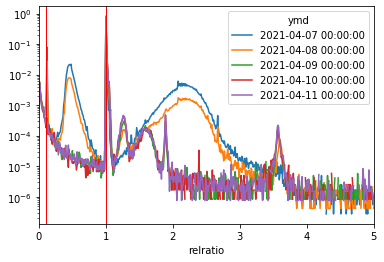

In [25]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
df[df.ymd >= '2021-04-07'].set_index(['relratio', 'ymd']).sort_index().frac.unstack('ymd').plot(ax=ax)
ax.set(xlim=[0, 5], 
       yscale='log'
      )
ax.axvline(1, **axline_kws)
ax.axvline(0.1, **axline_kws)

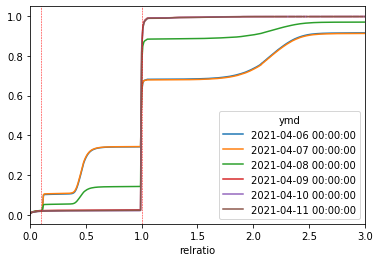

In [26]:
mask = df.ymd >= '2021-04-06'
fig, ax = plt.subplots(1,1,figsize=(6,4))
df[mask].set_index(['relratio', 'ymd']).sort_index().frac.unstack('ymd').cumsum().plot(ax=ax)
ax.set(xlim=[0, 3], 
#        yscale='log'
      )
ax.axvline(0.1, linestyle='--', color='r', linewidth=0.5)
ax.axvline(1, linestyle='--', color='r', linewidth=0.5)

## Scenario: Adding variables to queries
topics: string replacement



In [27]:
db = 'gleyson'
table_name = 'basic_sanity_check'

### Option 1: Literal string interpolation
When the prefix 'f' is added in front of the string, expressions in braces '{...}' are replaced by their values.

In [28]:
query = f'''
create {db}.{table_name}
    stored as parquet as 
select
    -- indices
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control') AS group_id,
    ssm.ymd as ymd,
    -- aggreates
    count(*) as visits,
    avg(ssm.pc_cos) as clickouts,
    avg(ssm.clickout_rev) as revenue
from
    trivago_analytic.session_stats_master as ssm
where
    ssm.crawler_id = 0
    and ssm.is_core
    and (array_contains(tags, 'releasecontrol'))
    -- ymd filter
    and ymd between 20210621 and 20210705
    -- traffic filter
    and (array_contains(control_group_set_php.mantis_id, 57256L)
         or array_contains(test_group_set_php.mantis_id, 57256L))
    and ssm.session_date_id between 2021062118*1e9 and 2021070523999999999
    and substr(cast(ssm.release_string as string), 1, 4) in ('9306', 'arp', '9307')
group by    
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control'),
    ssm.ymd
'''
print(query)


create gleyson.basic_sanity_check
    stored as parquet as 
select
    -- indices
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control') AS group_id,
    ssm.ymd as ymd,
    -- aggreates
    count(*) as visits,
    avg(ssm.pc_cos) as clickouts,
    avg(ssm.clickout_rev) as revenue
from
    trivago_analytic.session_stats_master as ssm
where
    ssm.crawler_id = 0
    and ssm.is_core
    and (array_contains(tags, 'releasecontrol'))
    -- ymd filter
    and ymd between 20210621 and 20210705
    -- traffic filter
    and (array_contains(control_group_set_php.mantis_id, 57256L)
         or array_contains(test_group_set_php.mantis_id, 57256L))
    and ssm.session_date_id between 2021062118*1e9 and 2021070523999999999
    and substr(cast(ssm.release_string as string), 1, 4) in ('9306', 'arp', '9307')
group by    
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control'),
    ssm.ymd



### Option 2: format method
The `format()` method formats the specified value(s) and insert them inside the string's placeholder.

In [29]:
query = '''
create {db}.{table_name}
    stored as parquet as 
select
    -- indices
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control') AS group_id,
    ssm.ymd as ymd,
    -- aggreates
    count(*) as visits,
    avg(ssm.pc_cos) as clickouts,
    avg(ssm.clickout_rev) as revenue
from
    trivago_analytic.session_stats_master as ssm
where
    ssm.crawler_id = 0
    and ssm.is_core
    and (array_contains(tags, 'releasecontrol'))
    -- ymd filter
    and ymd between 20210621 and 20210705
    -- traffic filter
    and (array_contains(control_group_set_php.mantis_id, 57256L)
         or array_contains(test_group_set_php.mantis_id, 57256L))
    and ssm.session_date_id between 2021062118*1e9 and 2021070523999999999
    and substr(cast(ssm.release_string as string), 1, 4) in ('9306', 'arp', '9307')
group by    
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control'),
    ssm.ymd
'''
print(query.format(db=db, table_name=table_name))


create gleyson.basic_sanity_check
    stored as parquet as 
select
    -- indices
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control') AS group_id,
    ssm.ymd as ymd,
    -- aggreates
    count(*) as visits,
    avg(ssm.pc_cos) as clickouts,
    avg(ssm.clickout_rev) as revenue
from
    trivago_analytic.session_stats_master as ssm
where
    ssm.crawler_id = 0
    and ssm.is_core
    and (array_contains(tags, 'releasecontrol'))
    -- ymd filter
    and ymd between 20210621 and 20210705
    -- traffic filter
    and (array_contains(control_group_set_php.mantis_id, 57256L)
         or array_contains(test_group_set_php.mantis_id, 57256L))
    and ssm.session_date_id between 2021062118*1e9 and 2021070523999999999
    and substr(cast(ssm.release_string as string), 1, 4) in ('9306', 'arp', '9307')
group by    
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control'),
    ssm.ymd



### Option 3: Dictionary unpacking

In [30]:
query_kws = dict(db=db, table_name=table_name)
print(query_kws)

{'db': 'gleyson', 'table_name': 'basic_sanity_check'}


In [31]:
print(query.format(**query_kws))


create gleyson.basic_sanity_check
    stored as parquet as 
select
    -- indices
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control') AS group_id,
    ssm.ymd as ymd,
    -- aggreates
    count(*) as visits,
    avg(ssm.pc_cos) as clickouts,
    avg(ssm.clickout_rev) as revenue
from
    trivago_analytic.session_stats_master as ssm
where
    ssm.crawler_id = 0
    and ssm.is_core
    and (array_contains(tags, 'releasecontrol'))
    -- ymd filter
    and ymd between 20210621 and 20210705
    -- traffic filter
    and (array_contains(control_group_set_php.mantis_id, 57256L)
         or array_contains(test_group_set_php.mantis_id, 57256L))
    and ssm.session_date_id between 2021062118*1e9 and 2021070523999999999
    and substr(cast(ssm.release_string as string), 1, 4) in ('9306', 'arp', '9307')
group by    
    if(array_contains(test_group_set_php.mantis_id, 57256L),
       'test', 'control'),
    ssm.ymd

